# Modelisation supervisee

### Import des modules

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import my_functions
import numpy as np
from pandas.api.types import CategoricalDtype
from scipy import stats
import mlflow
import mlflow.sklearn

In [78]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


In [79]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment('energy_building_predict')

<Experiment: artifact_location='mlflow-artifacts:/227936701966383927', creation_time=1737648959360, experiment_id='227936701966383927', last_update_time=1737648959360, lifecycle_stage='active', name='energy_building_predict', tags={}>

In [80]:
building_consumption = pd.read_csv("building_consumption_analized.csv")
building_consumption.head()

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,1927,1.0,12,88434,0,...,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,NaN,249.98,2.83
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,1996,1.0,11,103566,15064,...,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,NaN,295.86,2.86
2,NonResidential,Hotel,98101.0,7,DOWNTOWN,1969,1.0,41,956110,196718,...,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,NaN,2089.28,2.19
3,NonResidential,Hotel,98101.0,7,DOWNTOWN,1926,1.0,10,61320,0,...,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,NaN,286.43,4.67
4,NonResidential,Hotel,98121.0,7,DOWNTOWN,1980,1.0,18,175580,62000,...,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,NaN,505.01,2.88


In [81]:
building_consumption.shape

(1621, 30)

In [82]:
columnns_tracking = pd.read_csv('building_consumption_columns_tracking.csv')
columnns_tracking[columnns_tracking["selection"] != "non"]

,nom_colonne,selection,commentaires,description
2,BuildingType,NaN,NaN,Catégorie de batiment
3,PrimaryPropertyType,NaN,NaN,Type principal de propriété
8,ZipCode,NaN,NaN,Code postal
10,CouncilDistrictCode,NaN,NaN,Code du district
11,Neighborhood,NaN,NaN,Quartier
14,YearBuilt,NaN,NaN,Année de construction
15,NumberofBuildings,NaN,NaN,Nombre de bâtiments
16,NumberofFloors,NaN,NaN,Nombre d'étages
17,PropertyGFATotal,NaN,NaN,Surface totale
18,PropertyGFAParking,NaN,NaN,Surface de stationnement


## Feature Engineering

## Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de features) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

### Séparation dataset

In [83]:
with mlflow.start_run(run_name="Dataset Information"):
    # Séparation des features (X) et de la target (y)
    X = building_consumption[["PrimaryPropertyType","YearBuilt","CouncilDistrictCode","PropertyGFATotal","PropertyGFABuilding(s)","NumberofFloors"]]
    y = building_consumption["SiteEUI(kBtu/sf)"]

    # Vérification des shapes
    print(X.shape)
    print(y.shape)

    # Log les dimensions du dataset comme paramètres
    mlflow.log_param("X_shape", X.shape)
    mlflow.log_param("y_shape", y.shape)

    # Loguer des informations sur le dataset dans les tags
    mlflow.set_tag("dataset_name", "building_consumption_selec")
    mlflow.set_tag("features", list(X.columns))
    mlflow.set_tag("target", y.name)

(1621, 6)
(1621,)
🏃 View run Dataset Information at: http://127.0.0.1:5000/#/experiments/227936701966383927/runs/de1f57c514a6499b8f11b2a7b8adad47
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/227936701966383927


### Préparation variable cible

Text(0.15, 0.75, 'Écart-type: 74.47')

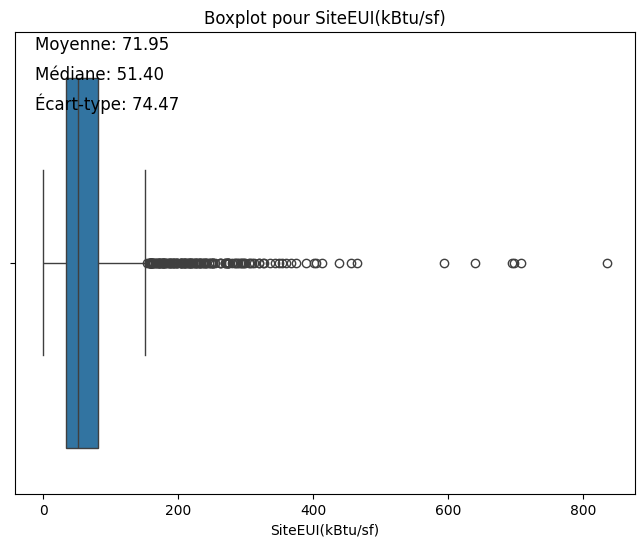

In [84]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=y)
plt.title(f'Boxplot pour SiteEUI(kBtu/sf)')
            
# Calcul des statistiques
mean = y.mean()
median = y.median()
std_dev = y.std()
            
# Affichage des statistiques sur le graphique
plt.figtext(0.15, 0.85, f'Moyenne: {mean:.2f}', fontsize=12)
plt.figtext(0.15, 0.80, f'Médiane: {median:.2f}', fontsize=12)
plt.figtext(0.15, 0.75, f'Écart-type: {std_dev:.2f}', fontsize=12)

### Préparation features

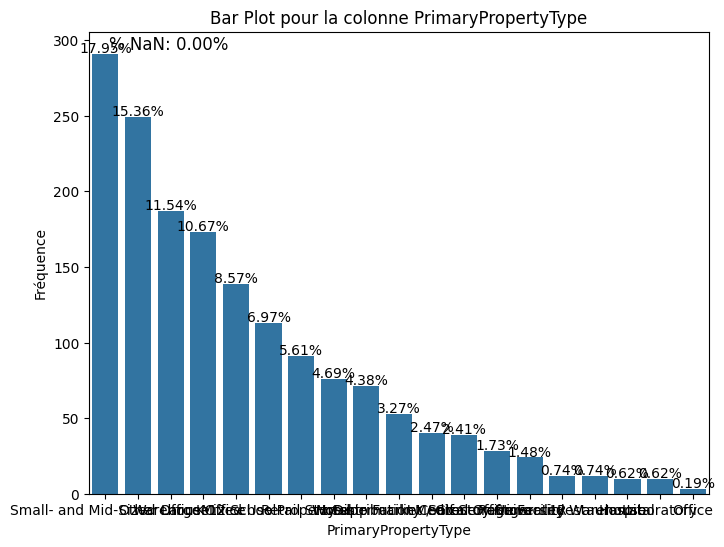

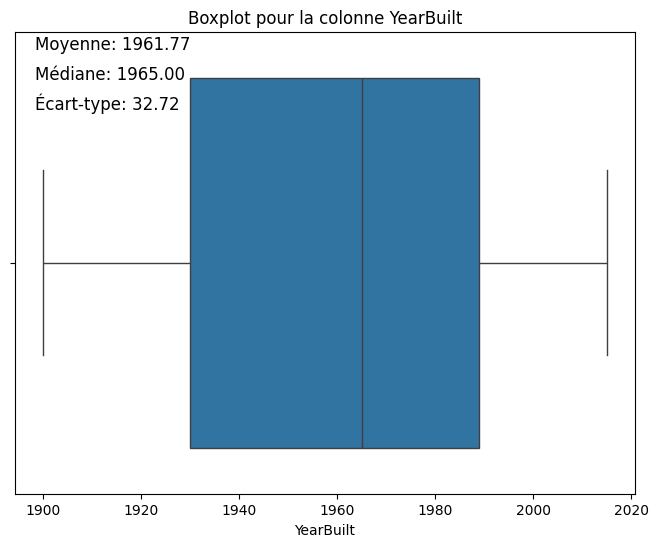

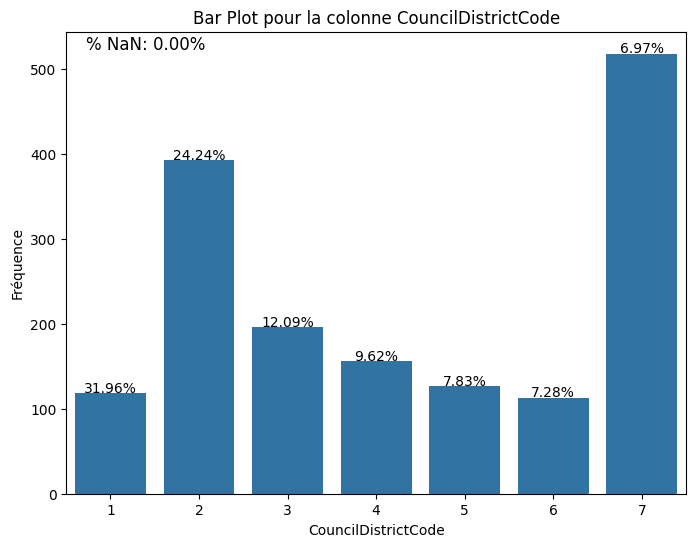

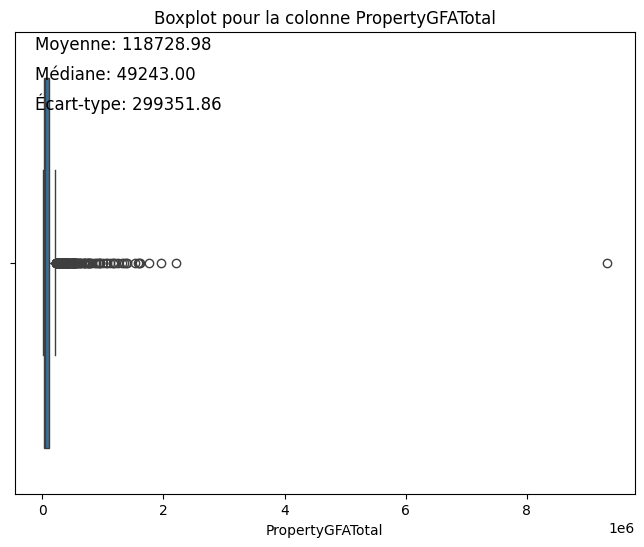

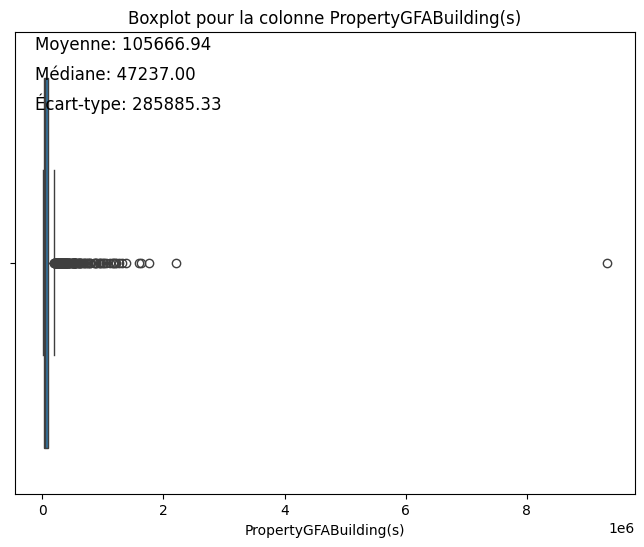

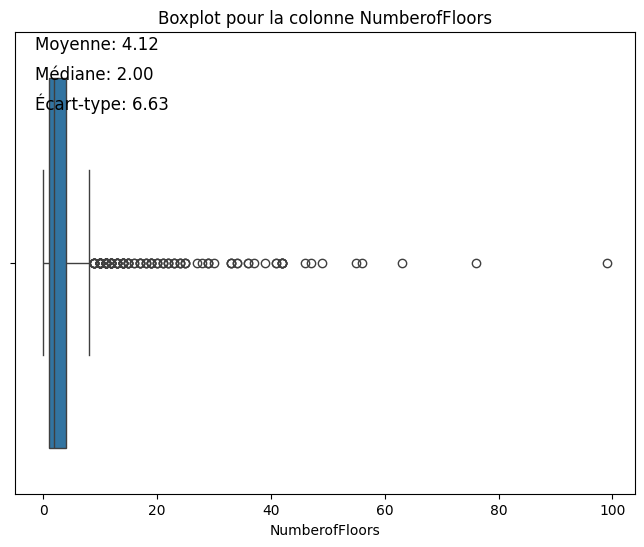

In [85]:
X_types = my_functions.identify_column_types(X)
my_functions.plot_column_analysis(X, X_types)

#### Outliers

#### Encodage

In [86]:
#PrimaryPropertyType
enc = OneHotEncoder()
labels = enc.fit_transform(X["PrimaryPropertyType"].values.reshape(-1, 1)).toarray()
encoded_columns = pd.DataFrame(labels, columns=enc.get_feature_names_out(['PrimaryPropertyType']))

X = X.drop('PrimaryPropertyType', axis=1).reset_index(drop=True)
X = pd.concat([X, encoded_columns], axis=1)

X.shape

(1621, 24)

## Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

### Modèle linéaire

In [87]:
# Séparation du dataset en Train et Test (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling des features (normalisation)
rl_scaler = StandardScaler()
X_train_scaled = rl_scaler.fit_transform(X_train)
X_test_scaled = rl_scaler.transform(X_test)

with mlflow.start_run(run_name ="model_linear_regression"):

    #Initialisation du modèle de régression
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Prédiction sur le jeu de test
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Calcul des métriques de performance pour le jeu d'entraînement
    r2_train_rl = r2_score(y_train, y_pred_train)
    mae_train_rl = mean_absolute_error(y_train, y_pred_train)
    rmse_train_rl = np.sqrt(mean_squared_error(y_train, y_pred_train))

    # Calcul des métriques de performance pour le jeu de test
    r2_test_rl = r2_score(y_test, y_pred_test)
    mae_test_rl = mean_absolute_error(y_test, y_pred_test)
    rmse_test_rl = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Log des métriques dans MLflow
    mlflow.log_metric('R2 Train', r2_train_rl)
    mlflow.log_metric('MAE Train', mae_train_rl)
    mlflow.log_metric('RMSE Train', rmse_train_rl)

    mlflow.log_metric('R2 Test', r2_test_rl)
    mlflow.log_metric('MAE Test', mae_test_rl)
    mlflow.log_metric('RMSE Test', rmse_test_rl)

    # Log du modèle dans MLflow
    mlflow.sklearn.log_model(model, 'linear_regression_model')

    # Log du scaler dans MLflow
    mlflow.set_tag("scaler", rl_scaler)

    # Affichage des résultats
    print("Métriques sur le jeu d'entraînement:")
    print(f"R2 : {r2_train_rl}")
    print(f"MAE : {mae_train_rl}")
    print(f"RMSE : {rmse_train_rl}")

    print("\nMétriques sur le jeu de test:")
    print(f"R2 : {r2_test_rl}")
    print(f"MAE : {mae_test_rl}")
    print(f"RMSE : {rmse_test_rl}")

2025/01/23 17:43:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Métriques sur le jeu d'entraînement:
R2 : 0.3410398588015623
MAE : 34.20651352302154
RMSE : 60.067802837064434

Métriques sur le jeu de test:
R2 : 0.27388709015902457
MAE : 33.910414625672374
RMSE : 64.94993708491945
🏃 View run model_linear_regression at: http://127.0.0.1:5000/#/experiments/227936701966383927/runs/3232522dd5684c3c8d8e6780be6a32f7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/227936701966383927


### Random Forest

In [88]:
with mlflow.start_run(run_name ="model_random_forest"):

    # Initialisation du modèle
    rf_model = RandomForestRegressor(random_state=42)

    # Entraînement du modèle
    rf_model.fit(X_train, y_train)

    # Prédictions
    y_pred_train_rf = rf_model.predict(X_train)
    y_pred_test_rf = rf_model.predict(X_test)

    # Calcul des métriques
    r2_train_rf = r2_score(y_train, y_pred_train_rf)
    mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
    rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))

    r2_test_rf = r2_score(y_test, y_pred_test_rf)
    mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
    rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))

    # Log des métriques dans MLflow
    mlflow.log_metric('R2 Train', r2_train_rf)
    mlflow.log_metric('MAE Train', mae_train_rf)
    mlflow.log_metric('RMSE Train', rmse_train_rf)

    mlflow.log_metric('R2 Test', r2_test_rf)
    mlflow.log_metric('MAE Test', mae_test_rf)
    mlflow.log_metric('RMSE Test', rmse_test_rf)

    # Log du modèle dans MLflow
    mlflow.sklearn.log_model(model, 'random_forest_model')

    # Affichage des résultats
    print("Random Forest - Métriques sur le jeu d'entraînement:")
    print(f"R2 : {r2_train_rf}")
    print(f"MAE : {mae_train_rf}")
    print(f"RMSE : {rmse_train_rf}")

    print("\nRandom Forest - Métriques sur le jeu de test:")
    print(f"R2 : {r2_test_rf}")
    print(f"MAE : {mae_test_rf}")
    print(f"RMSE : {rmse_test_rf}")

2025/01/23 17:44:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Métriques sur le jeu d'entraînement:
R2 : 0.9025187556424971
MAE : 13.311842014054294
RMSE : 23.103230217279187

Random Forest - Métriques sur le jeu de test:
R2 : 0.4190962667863072
MAE : 32.42284628660034
RMSE : 58.093660091322455
🏃 View run model_random_forest at: http://127.0.0.1:5000/#/experiments/227936701966383927/runs/a9dd22d92a8d48c68c87562e6734aa8a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/227936701966383927


### Modèle SVM

In [89]:
# Scaling des features
svm_scaler = StandardScaler()
X_train_scaled = svm_scaler.fit_transform(X_train)
X_test_scaled = svm_scaler.transform(X_test)

with mlflow.start_run(run_name = "model_svm"):
    # Initialisation du modèle SVM avec un noyau RBF
    svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

    # Entraînement du modèle
    svm_model.fit(X_train_scaled, y_train)

    # Prédictions
    y_pred_train_svm = svm_model.predict(X_train_scaled)
    y_pred_test_svm = svm_model.predict(X_test_scaled)

    # Calcul des métriques
    r2_train_svm = r2_score(y_train, y_pred_train_svm)
    mae_train_svm = mean_absolute_error(y_train, y_pred_train_svm)
    rmse_train_svm = np.sqrt(mean_squared_error(y_train, y_pred_train_svm))

    r2_test_svm = r2_score(y_test, y_pred_test_svm)
    mae_test_svm = mean_absolute_error(y_test, y_pred_test_svm)
    rmse_test_svm = np.sqrt(mean_squared_error(y_test, y_pred_test_svm))

    # Log des métriques dans MLflow
    mlflow.log_metric('R2 Train', r2_train_svm)
    mlflow.log_metric('MAE Train', mae_train_svm)
    mlflow.log_metric('RMSE Train', rmse_train_svm)

    mlflow.log_metric('R2 Test', r2_test_svm)
    mlflow.log_metric('MAE Test', mae_test_svm)
    mlflow.log_metric('RMSE Test', rmse_test_svm)

    # Log du modèle dans MLflow
    mlflow.sklearn.log_model(model, 'svm_model')

    # Log du scaler dans MLflow
    mlflow.set_tag("scaler", svm_scaler)

    # Affichage des résultats
    print("SVM - Métriques sur le jeu d'entraînement:")
    print(f"R2 : {r2_train_svm}")
    print(f"MAE : {mae_train_svm}")
    print(f"RMSE : {rmse_train_svm}")

    print("\nSVM - Métriques sur le jeu de test:")
    print(f"R2 : {r2_test_svm}")
    print(f"MAE : {mae_test_svm}")
    print(f"RMSE : {rmse_test_svm}")

2025/01/23 17:44:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM - Métriques sur le jeu d'entraînement:
R2 : 0.04250087859900842
MAE : 36.69048953814223
RMSE : 72.40713532575266

SVM - Métriques sur le jeu de test:
R2 : 0.05190084563147446
MAE : 37.28199717912404
RMSE : 74.21702390077573
🏃 View run model_svm at: http://127.0.0.1:5000/#/experiments/227936701966383927/runs/e4fe980344554c7db41057ee51e4fdc3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/227936701966383927


In [90]:
metrics_data = pd.DataFrame({
    "Modèle": ["Régression Linéaire", "Random Forest", "SVM"],
    "R2 Train": [r2_train_rl, r2_train_rf, r2_train_svm],
    "MAE Train": [mae_train_rl, mae_train_rf, mae_train_svm],
    "RMSE Train": [rmse_train_rl, rmse_train_rf, rmse_train_svm],
    "R2 Test": [r2_test_rl, r2_test_rf, r2_test_svm],
    "MAE Test": [mae_test_rl, mae_test_rf, mae_test_svm],
    "RMSE Test": [rmse_test_rl, rmse_test_rf, rmse_test_svm],
})

metrics_data


,Modèle,R2 Train,MAE Train,RMSE Train,R2 Test,MAE Test,RMSE Test
0,Régression Linéaire,0.341040,34.206514,60.067803,0.273887,33.910415,64.949937
1,Random Forest,0.902519,13.311842,23.103230,0.419096,32.422846,58.093660
2,SVM,0.042501,36.690490,72.407135,0.051901,37.281997,74.217024


## Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [91]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE